# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.display import display

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import sklearn
import re

import statsmodels.api as sm 
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('whitegrid')

from __future__ import division
from math import *
from scipy import integrate
from numpy import inf, pi
from sklearn.neighbors import KernelDensity
from sklearn import mixture

from windrose import WindroseAxes, WindAxes

from helpers.utility_helper import *
from helpers.app_helper import *
from helpers.gmm_helper import *
from helpers.plot_helper import *

## 1.2 Read Data

In [2]:
# ipath = './data/NCDC/boscombe_down/3466726903106dat.txt'
# ipath = './data/NCDC/ciampino/6240476818161dat.txt'
# ipath = './data/NCDC/tiree.txt'
ipath= "./data/NCDC/marham.txt"
# ipath= "./data/NCDC/上海/虹桥/9705626661750dat.txt"

# ipath= './data/NCDC/tenerife_sur/5894676958432dat.txt'
# ipath= './data/NCDC/kennedy/5807936958436dat.txt'
# ipath= './data/NCDC/newark/8455636958433dat.txt'
# ipath= './data/NCDC/la_guardia/1057036958434dat.txt'

# ipath= './data/NCDC/macau/8518316959352dat.txt'
# ipath= "./data/NCDC/baltimore/9963956959409dat.txt"
# ipath= "./data/NCDC/南京lukou/7271776959346dat.txt"
# ipath= "./data/NCDC/武汉tianhe/5855286959350dat.txt"

# ipath= "./data/NCDC/olympia_airport/2647036962786dat.txt" # dataset has some problem
# ipath= "./data/NCDC/carlos_ibanez/9844226962789dat.txt" # problem dataset
# ipath= "./data/NCDC/sidney/6062326959357dat.txt" # problem dataset, report time not integer
# ipath= "./data/NCDC/auckland/4774046962787dat.txt" 
# ipath= "./data/NCDC/huspel_aws/7901916962788dat.txt" 

uipath = unicode(ipath , "utf8")

df = pd.read_csv(uipath,header=0, skipinitialspace=True)
df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type'}, inplace=True)
df = df[['date','HrMn','type','dir','speed' ]]

In [3]:
# select year 1945-2014, dir < 999, speed<999
df = df.query("(dir < 999) & (speed < 999) & \
              (date >= 19800000) & (date < 20160000) & \
              (HrMn % 5 == 0 )")

# Turn dir into [0,360), some station are[10,360],some are [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360)
df.index= df['date']
df.describe()

,date,HrMn,dir,speed
count,447243.000000,447243.000000,447243.000000,447243.000000
mean,19998783.907153,1168.281851,184.857391,4.739733
std,101492.086192,688.968703,93.912703,2.699617
min,19800101.000000,0.000000,0.000000,0.500000
25%,19910701.000000,600.000000,120.000000,2.600000
50%,20020116.000000,1200.000000,200.000000,4.100000
75%,20090227.000000,1750.000000,250.000000,6.200000
max,20150801.000000,2355.000000,350.000000,28.000000


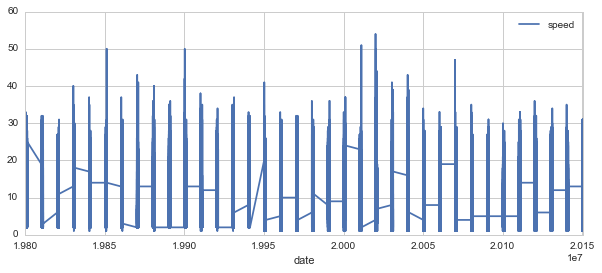

In [4]:
# Using speed unit in knot instead of m/s
# need more elaboration, some is not near an integer
if re.findall(ur'[\u4e00-\u9fff]+', uipath): 
    knot_unit = False
elif 'huspel' in ipath:
    knot_unit = False
else:
    df.rename(columns={'speed':'speed_mps'}, inplace=True)
    df['speed']=df['speed_mps']
    df['speed']=df['speed_mps']*1.943845
    df['speed']=df['speed'].apply(lambda x: int(round(x)))
    knot_unit = True

df['speed'].plot(legend=True,figsize=(10,4), grid=True)

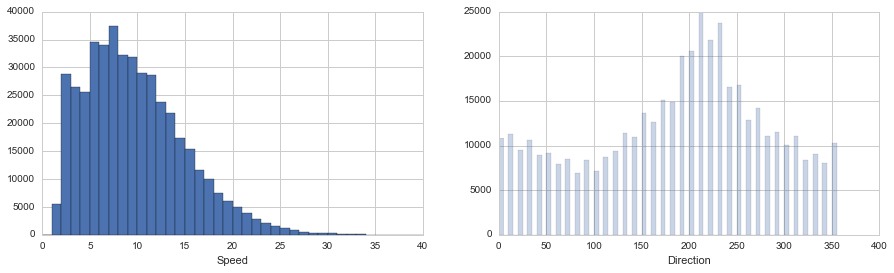

In [5]:
# Notice the gap of the distributions, so futher process needed, as below
plot_speed_and_angle_distribution(df)

## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

,date,HrMn,type,dir,speed_mps,speed,incre,incre_reverse
date,,,,,,,,
20020128,20020128,1700,FM-12,240,28.0,54,26,27
20011228,20011228,1400,FM-12,280,26.0,51,25,30
20020304,20020304,50,FM-15,40,25.7,50,44,46
19851113,19851113,900,FM-12,220,25.7,50,40,45
19900223,19900223,1000,SY-MT,290,25.7,50,43,45
20070118,20070118,1250,FM-15,270,24.2,47,17,0
20070118,20070118,1300,FM-12,270,24.2,47,0,12
20021027,20021027,1000,FM-12,250,22.6,44,10,32
20070118,20070118,1500,FM-12,270,22.1,43,0,3


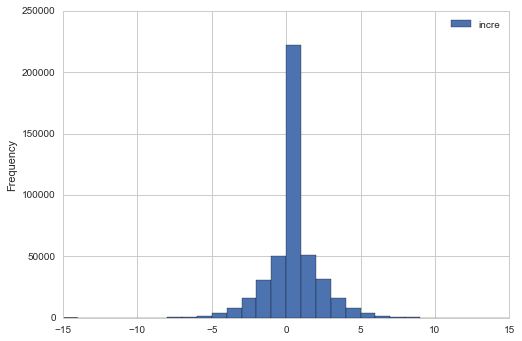

In [6]:
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0)
display(df.sort_values(by='speed',ascending=False).head(10))
bins=np.arange(-15, 15 + 1, 1)
df['incre'].plot(kind='hist', bins=bins, legend=True)

In [7]:
# Simple Artefacts Handling
incre_threshold = 20 if knot_unit else 10
df = df.query('(incre < @incre_threshold )&(incre_reverse < @incre_threshold )')
df = df.query('dir % 10 <= 0.1')

After Simple Aretefacts Handling

In [8]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,type,dir,speed_mps,speed,incre,incre_reverse
date,,,,,,,,
20070118,20070118,1250,FM-15,270,24.2,47,17,0
20070118,20070118,1300,FM-12,270,24.2,47,0,12
20070118,20070118,1450,FM-15,270,22.1,43,8,0
20070118,20070118,1500,FM-12,270,22.1,43,0,3
20040320,20040320,1600,FM-12,250,22.1,43,3,8
19900226,19900226,700,FM-12,230,22.1,43,9,18
19870327,19870327,1400,SY-MT,220,22.1,43,7,3
19900125,19900125,1650,FM-15,250,21.6,42,3,0
19900125,19900125,1700,SY-MT,250,21.6,42,0,4


### 1.3.2 Sampling Time Selection

In [9]:
df['HrMn'].value_counts().sort_index()

0       12102
5           3
10          3
15          1
20          5
25          2
30         10
35          1
50       6107
55          1
100     12155
105         1
110         1
120         5
130         3
135         2
150      6212
155         1
200     12123
205         2
220         8
225         1
230         9
240         1
245         2
250      6289
255         2
300     12025
310         3
315         1
        ...  
2045        2
2050     6117
2100    12177
2105        1
2110        2
2115        4
2120        3
2125        1
2130        5
2140        2
2145        2
2150     6111
2155        1
2200    12213
2205        1
2210        1
2220        5
2225        2
2230        2
2235        1
2250     6217
2300    12242
2305        2
2315        1
2320        8
2325        2
2330        9
2345        2
2350     6318
2355        5
Name: HrMn, dtype: int64

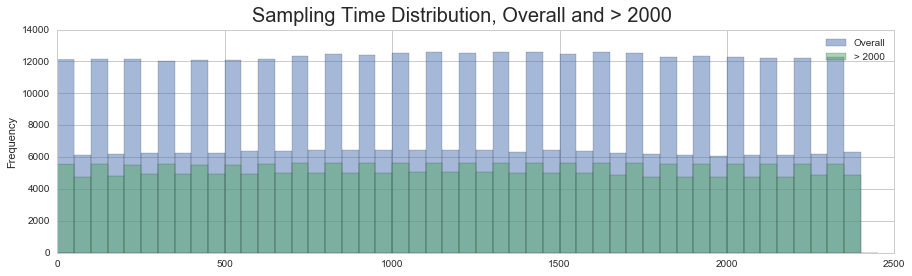

In [10]:
# Ensure data sampled equally
bins=np.arange(min(df.HrMn), max(df.HrMn) + 100, 50)

df['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='Overall')

df.query('date > 20000000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> 2000' )

plt.suptitle('Sampling Time Distribution, Overall and > 2000', fontsize = 20)
plt.legend()

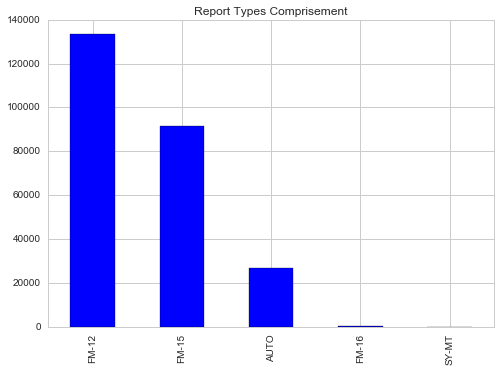

In [11]:
df.query("date >= 20000000 ")['type'].value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement')

report_type_most_used = df.query("date >= 20000000 ")['type'].value_counts().argmax()

In [12]:
# Data Selection
if "ciampino" in ipath: 
    df = df[(df['HrMn'] % 100 == 15)|(df['HrMn'] % 100 == 45)|(df['HrMn'] % 100 == 20)|(df['HrMn'] % 100 == 50)]
elif 'olympia' in ipath:
    df = df 
else: 
    df = df.query('HrMn % 100 <= 0.1')

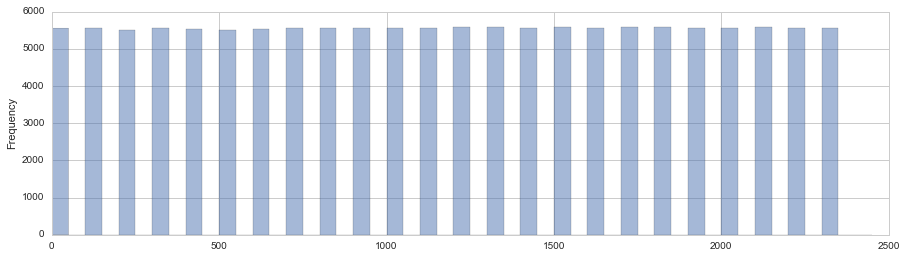

In [13]:
df = df.query("type==@report_type_most_used")

df.query('date > 20000000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins)

## 1.3.3 Time Shift Comparison

In [14]:
mid_time = ((min(df.date)+max(df.date))/2 )
start_year = int(ceil(min(df.date) /10000))
end_year = 2015
mid_year = int(np.average([start_year, end_year]))

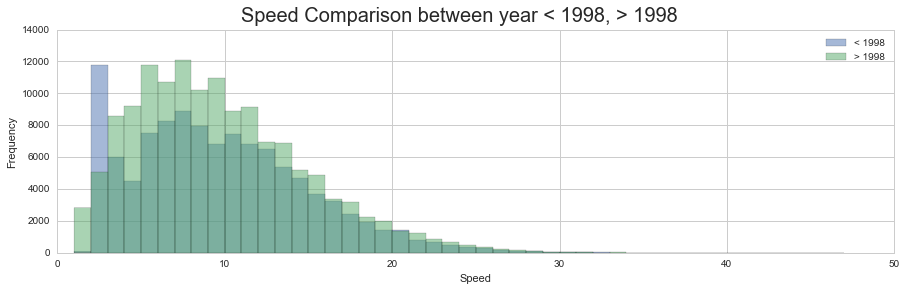

In [15]:
# Comparison between year < 2000, and > 2000, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = np.arange(min(df.speed), max(df.speed) + 1, 1)
df[df['date'] < mid_year * 10000]['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % mid_year)

df[df['date'] > mid_year * 10000]['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % mid_year)

plt.xlabel("Speed")
plt.suptitle('Speed Comparison between year < %s, > %s ' % (mid_year, mid_year), fontsize = 20)
plt.legend()

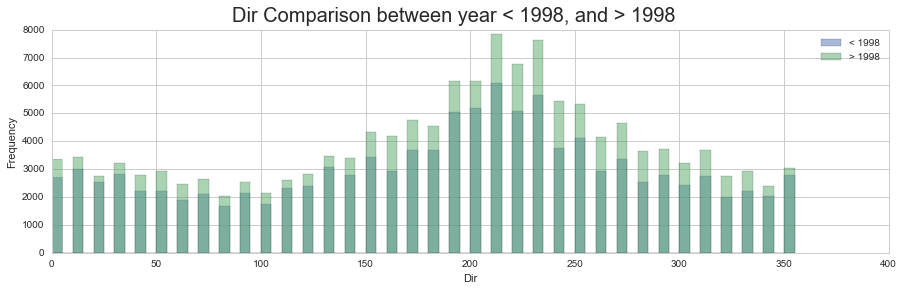

In [16]:
bins=np.arange(min(df.dir), max(df.dir) + 10, 5)
df[df['date'] < mid_year * 10000]['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % mid_year)

df[df['date'] > mid_year * 10000]['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % mid_year)

plt.xlabel("Dir")
plt.suptitle('Dir Comparison between year < %s, and > %s ' % (mid_year, mid_year), fontsize = 20)
plt.legend()

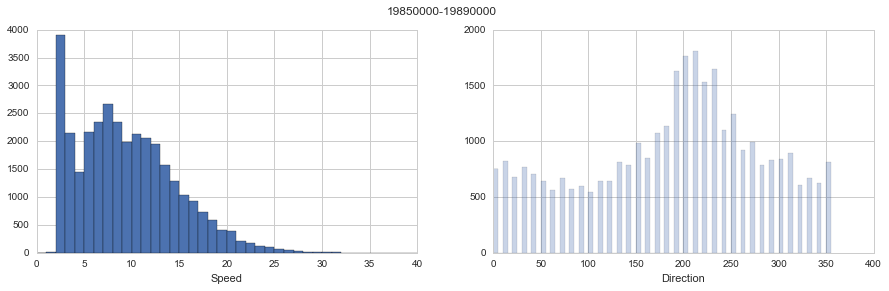

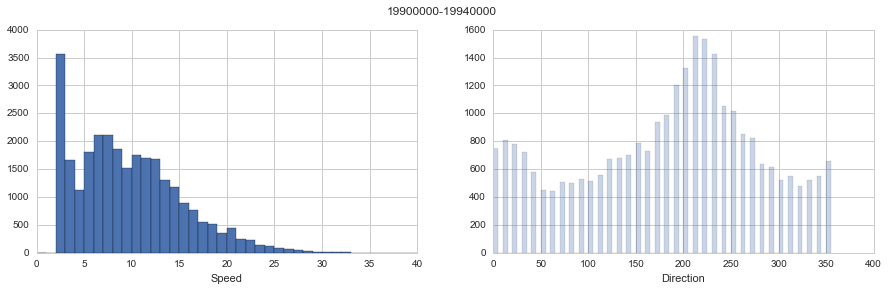

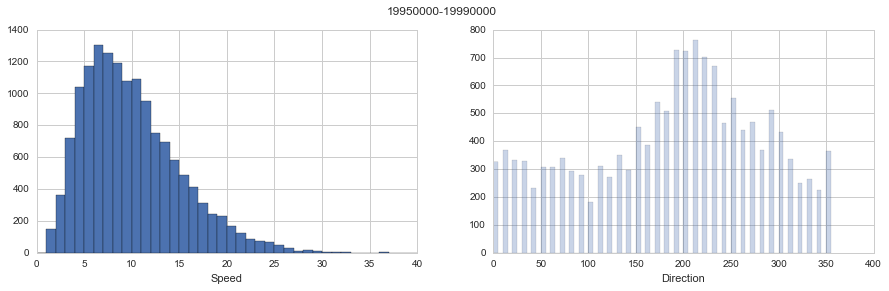

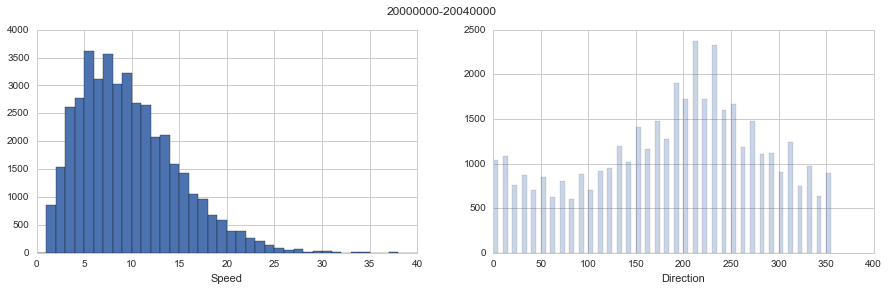

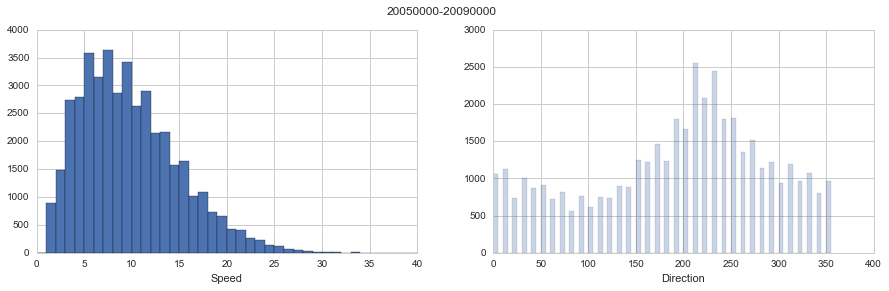

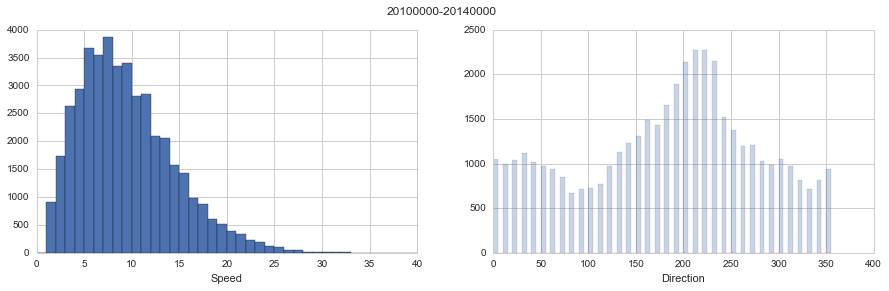

In [17]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    for start_time in xrange(19850000, 20150000, 50000):
        end_time = start_time + 50000 
        sub_df = df.query('(date >= @start_time) & (date < @end_time)')
        if len(sub_df) > 0 :
            title = str(start_time) +'-' + str(end_time-10000)
            plot_speed_and_angle_distribution(sub_df, title)
        
check_time_shift(df)

## 1.4 Re-select data, data conversion, and overview of the clean dataset

In [18]:
# Year range, Reports Type, Sampling Time
df = df.query('(date >= 20100000) & (date < 20150000)')

### 1.4.1 Overview

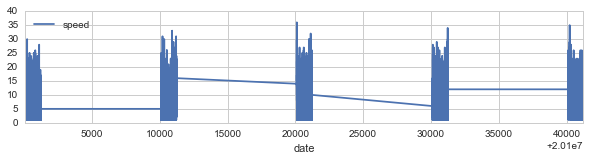

In [19]:
df['speed'].plot(legend=True,figsize=(10,2), grid=True)

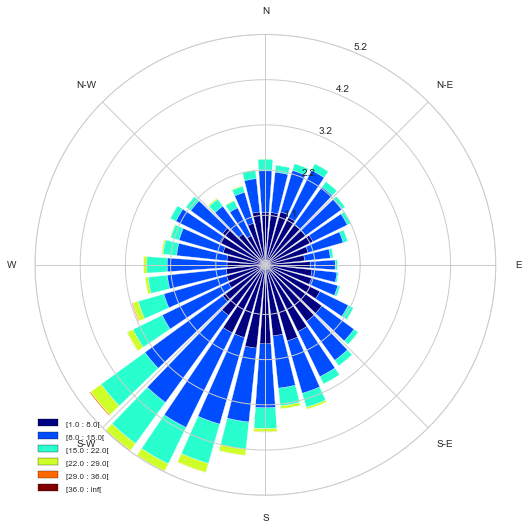

In [20]:
df.dir_windrose = df.dir
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

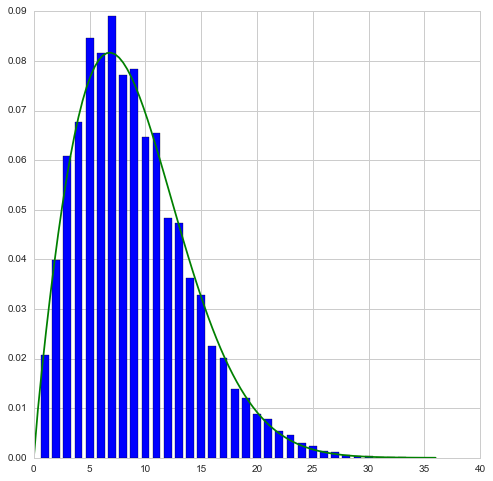

In [21]:
ax = WindAxes.from_ax()
bins=np.arange(min(df.speed), max(df.speed) + 1, 1)
ax, params = ax.pdf(df.speed, bins = bins)

In [22]:
print params
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)
print weibull_params

(1, 1.8888206776307812, 0, 10.12987941962098)
(1, 1.8888206776307812, 0, 10.12987941962098)


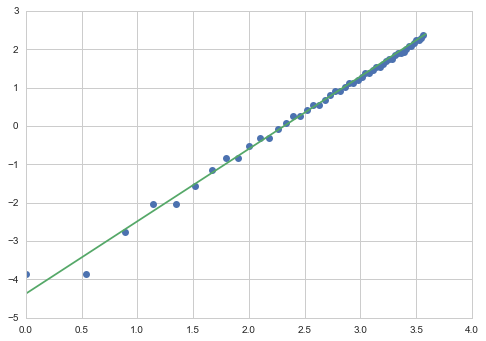

In [23]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

x = np.linspace(min(sample), max(sample))
w_scale = weibull_params[1]
c_shape = weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-')
plt.show()

### 1.4.2 Direction Conversion, from windrose to polar system
e.g. 0 degree = north, clockwise => 90 degree = north, counterclockwise

In [24]:
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360)

In [25]:
df['dir'].value_counts().sort_index()

0       712
10      674
20      845
30      939
40      973
50     1017
60     1113
70     1042
80      993
90     1048
100     944
110     816
120     712
130     815
140     972
150    1047
160     982
170    1032
180    1204
190    1195
200    1372
210    1522
220    2146
230    2277
240    2273
250    2136
260    1894
270    1653
280    1431
290    1485
300    1312
310    1235
320    1134
330     968
340     768
350     726
Name: dir, dtype: int64

### 1.4.3 Re-distribute Direction, within each sector (optional)
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [26]:
def randomize_angle(df):
    df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(-5,5))% 360)

    bins=np.arange(0, 360+10, 5)
    df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    bins=np.arange(0, 360+10, 1)
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran'], 1,inplace=True)
    return df

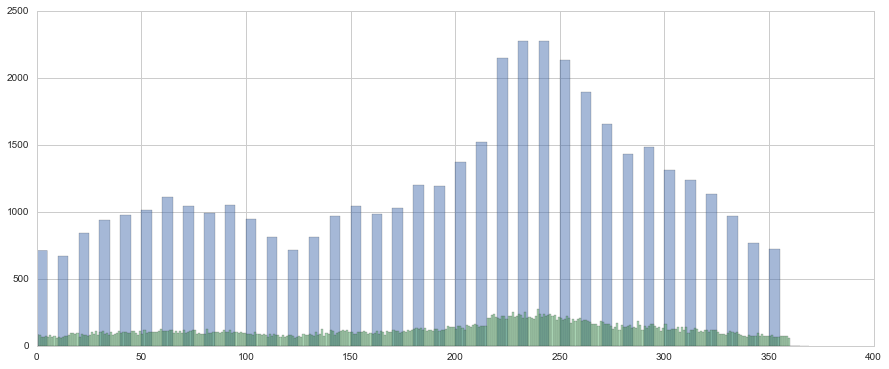

In [27]:
# Randomize the angle degree, to form a better KDE estimation
df['dir_int'] = df['dir']
df = randomize_angle(df)

### 1.4.4 Generate (x,y) from (speed,dir)

-1.69713349087 -2.01236255723


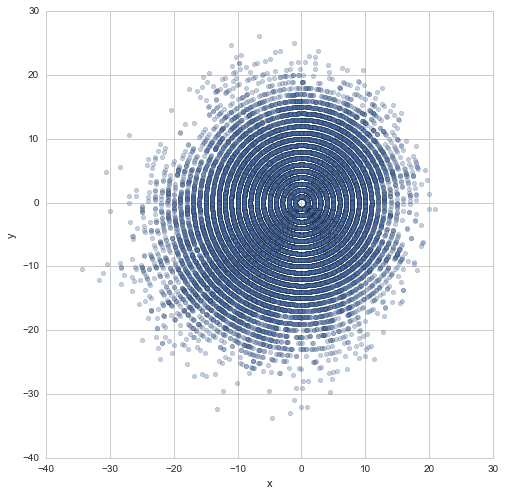

In [28]:
df['x'] = df['speed'] * np.cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * np.sin(df['dir'] * pi / 180.0)
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)
print np.mean(df.x), np.mean(df.y)

# 2. Create input data, i.e. speed_set

In [29]:
# speed_set = np.array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
speed_set = np.array(zip(df.x, df.y))
speed_angle_set = np.array(zip(df.speed, df.dir))
number_of_gaussian = 3

In [30]:
fitting_range = []
if knot_unit == True:
    fitting_axis_range = np.arange(-20, 21, 1)
    plot_axis_range = np.arange(-25, 25, 1)
else:
    fitting_axis_range = np.arange(-10, 11, 1)
    plot_axis_range = np.arange(-10, 11, 1)
    
for i in fitting_axis_range:
    for j in fitting_axis_range:
        fitting_range.append([i,j])

original_dim = int(np.sqrt(len(fitting_range))) 

# 3. Kernel Density Estimation

In [31]:
sample = speed_set
kde = KernelDensity(bandwidth=1).fit(sample) # need to consider the bandwidth for different sites

In [32]:
points = fitting_range
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = np.exp(kde.score_samples(points))
print kde_result[:5]
print len(kde_result)

[  1.24520036e-05   2.14417419e-05   3.45341389e-05   4.70235269e-05
   6.55156672e-05]
1681


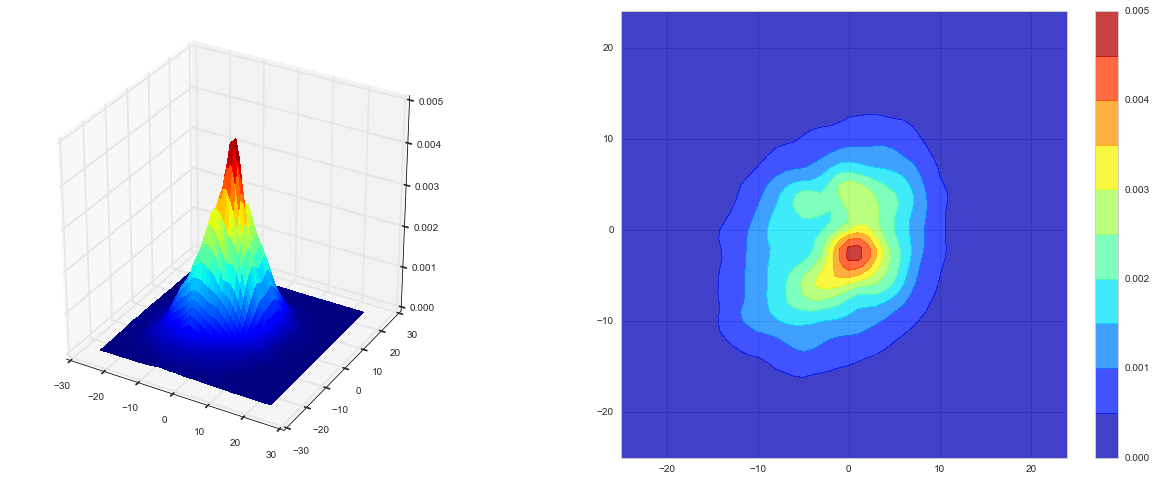

In [33]:
# Plot jPDF
X = Y = plot_axis_range
# Can't work if pass as generate_Z_from_X_Y(X,Y, np.exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: np.exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [34]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM Estimation, using EM algo

In [35]:
sample= speed_set
clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
clf.fit(sample)

clf.converged_

True

In [36]:
gmm_em_result = read_gmm_em_result(clf, print_result = False)
pretty_print_gmm(gmm_em_result)  

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.363729,1.432738,-3.941042,5.136618,6.250860,0.197348
1,0.334751,-0.451165,3.179628,5.782689,5.896283,0.062103
2,0.301520,-6.856042,-5.449964,6.292063,6.778811,0.107198


GMM Plot Result
0.363729118703 [[ 1.43273817 -3.94104241]] [ 4.87467319  6.45721774] 157.51740391
0.301520086806 [[-6.85604183 -5.44996437]] [ 6.09927183  6.95278493] 152.413863109
0.334750794491 [[-0.45116474  3.17962817]] [ 5.6465816   6.02675376] 143.696944313


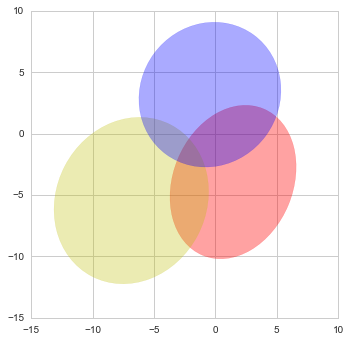

In [37]:
plot_gmm_ellipses(gmm_em_result)

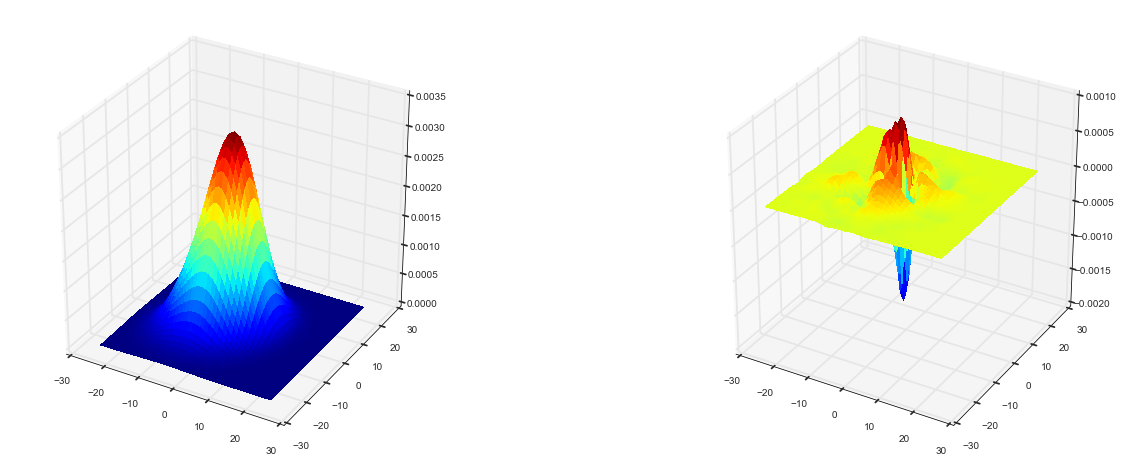

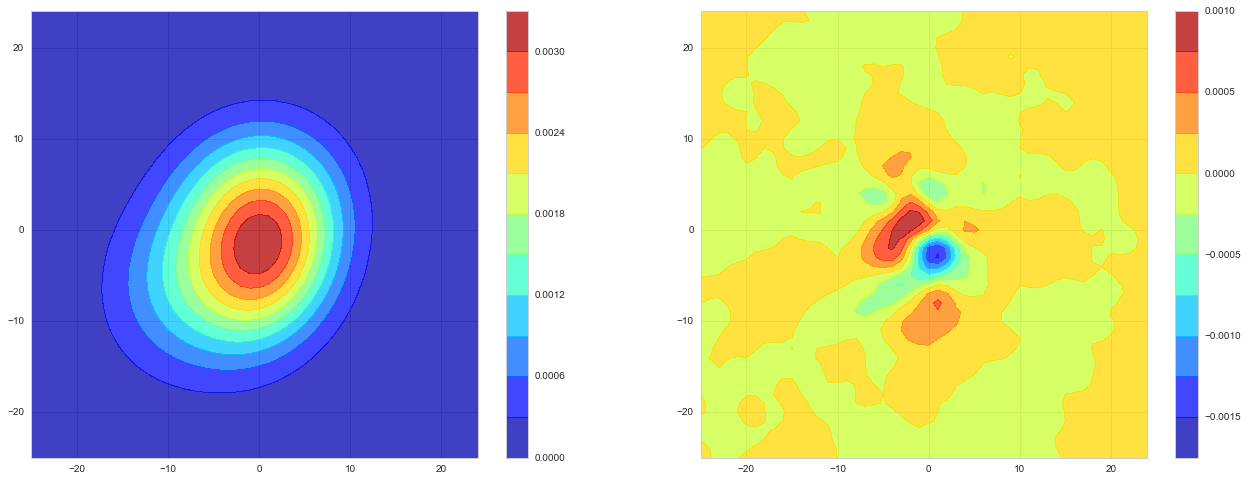

In [38]:
X = Y = plot_axis_range
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: np.exp(clf.score_samples(coords)[0]))

def residule_between_kde_and_gmm(points):
    kde_vals = np.exp(kde.score_samples(points))
    gmm_vals = np.exp(clf.score_samples(points)[0])
    return gmm_vals - kde_vals

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)
gmm_em_3d_fig = fig

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,residual_Z,ax2)
gmm_em_2d_fig = fig

## GMM, EM VS. KDE

In [39]:
points = fitting_range
gmm_pdf_result = np.exp(clf.score_samples(points)[0])

In [40]:
# put into Pandas to make it looks better
pd.DataFrame([goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,1261.313199,0.01467,2.937213e-08,0.036468,0.292334,0.956581


# 5. Least Square Prob Estimation

In [41]:
sample = speed_set
points = fitting_range

In [42]:
gmm_em_result = read_gmm_em_result(clf, print_result = False)
pretty_print_gmm(gmm_em_result)             

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.363729,1.432738,-3.941042,5.136618,6.250860,0.197348
1,0.334751,-0.451165,3.179628,5.782689,5.896283,0.062103
2,0.301520,-6.856042,-5.449964,6.292063,6.778811,0.107198


In [43]:
count = len(df)
def GMM_fit_score(gmm, kde_result, method = 'square_error'): 
    # 1. Create the GMM PDF
    if not isinstance(gmm[0], np.ndarray):
        gmm = group_gmm_param_from_gmm_param_array(gmm, sort_group = False)
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    # 2. Fit the model using different metrics
    gmm_pdf_result = mixed_model_pdf(points)
    if method == 'square_error':
        # 2.1 Square error
        error_array = np.power(gmm_pdf_result - kde_result,2)
        result = mse_log = np.log(np.average(error_array))
    elif method == 'chi_square':
        # 2.2 Chi square
        error_array = np.power(gmm_pdf_result - kde_result,2)
        # unable to * count = 43412
        result = chi_square_stat = sum(error_array/gmm_pdf_result) 
    elif method == 'K_S':
        # 2.3 K-S statistc
        gmm_cdf = cdf_from_pdf(gmm_pdf_result)
        diff = gmm_cdf - kde_cdf
        result = KS_stat = np.amax(diff)
    return result

# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
    # sum of every 6th element, which is the fraction of each gaussian
    {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
    # limit the width/height ratio of elliplse, optional
#     {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#     {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -18.237638455158628
     jac: array([  1.22847176e+00,   0.00000000e+00,   0.00000000e+00,
         2.38418579e-07,   2.38418579e-07,  -4.76837158e-07,
         1.22847939e+00,  -2.38418579e-07,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.22847962e+00,  -2.38418579e-07,   0.00000000e+00,
        -2.38418579e-07,  -2.38418579e-07,  -2.38418579e-07,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1151
     nit: 57
    njev: 57
  status: 0
 success: True
       x: array([ 0.08797207,  1.12112465, -2.9829132 ,  2.66918354,  2.30139312,
        0.3132315 ,  0.54028022, -2.56274859, -6.21668563,  7.45538193,
        5.51215075,  0.19316797,  0.37174771, -0.28364889,  4.25829053,
        6.7071711 ,  4.395679  ,  0.15579973])

## LRMSE VS. KDE

In [44]:
kde_result[:5]

array([  1.24520036e-05,   2.14417419e-05,   3.45341389e-05,
         4.70235269e-05,   6.55156672e-05])

In [45]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)

pretty_print_gmm(gmm)

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.540280,-2.562749,-6.216686,7.455382,5.512151,0.193168
1,0.371748,-0.283649,4.258291,6.707171,4.395679,0.155800
2,0.087972,1.121125,-2.982913,2.669184,2.301393,0.313231


GMM Plot Result
0.540280220942 [[-2.56274859 -6.21668563]] [ 5.30014812  7.60755911] -73.8935326631
0.371747711207 [[-0.28364889  4.25829053]] [ 4.30402634  6.76635022] -80.1523183907
0.0879720678511 [[ 1.12112465 -2.9829132 ]] [ 2.01996663  2.88802456] -57.7051096316


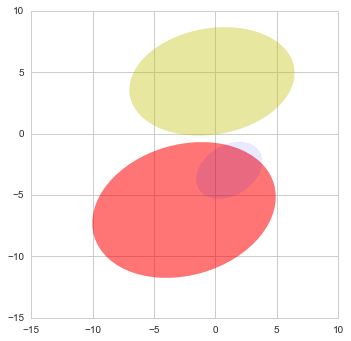

In [46]:
plot_gmm_ellipses(gmm)

## Goodness-of-fit indicators

In [47]:
pd.DataFrame(
    [goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,3172.114622,0.019798,1.200865e-08,0.023318,0.186921,0.982248


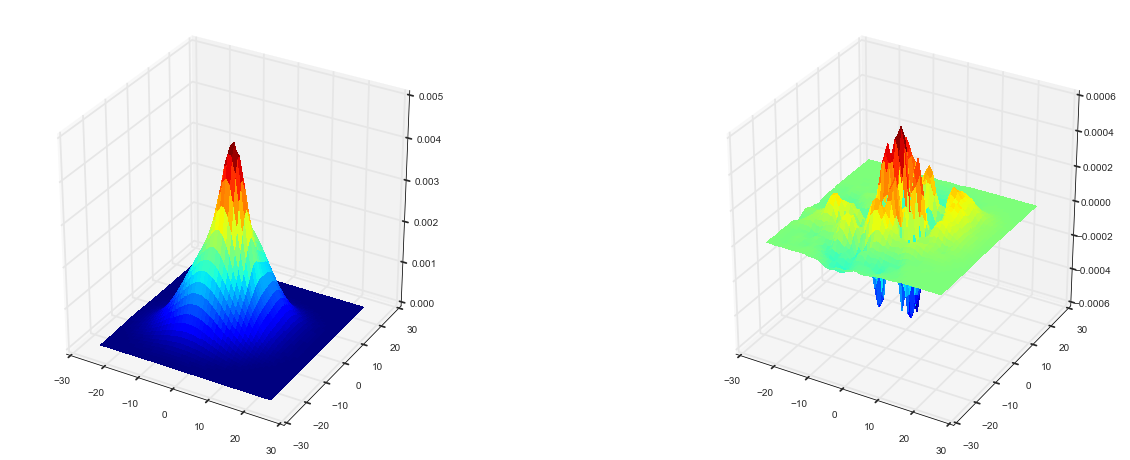

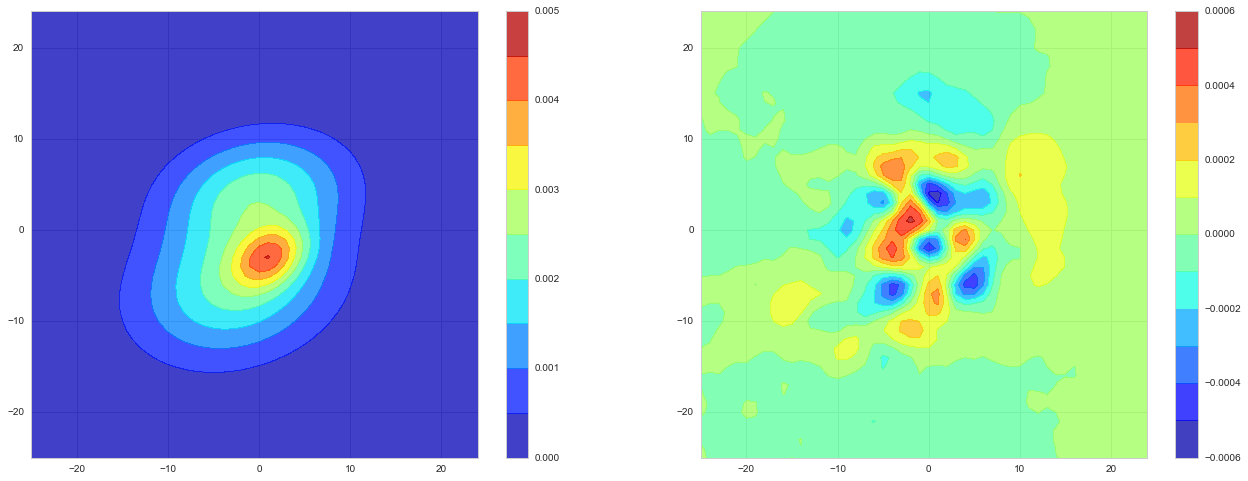

In [48]:
X = Y = plot_axis_range
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = np.exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return gmm_vals - kde_vals

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,residual_Z,ax2)

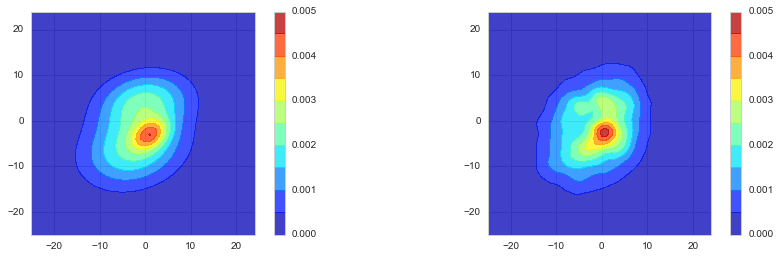

In [49]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [50]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = np.linspace(0,50)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*np.pi]]) for x_val in x_vals_OEN3_LMSE ]

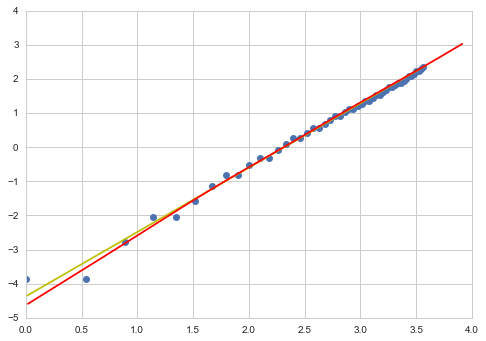

In [51]:
# Plot v-p points, empirical distribution
sample = df.speed
ecdf = sm.distributions.ECDF(sample)
x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

# Weibull distribution
x = np.linspace(min(sample), max(sample))
w_scale = weibull_params[1]
c_shape = weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-', color = 'y')

# OEN3 distribution, LMSE
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = np.array(zip(*y_)[0])
plt.plot(np.log(x), np.log(-np.log(1-y)),'-', color = 'r')

plt.show()

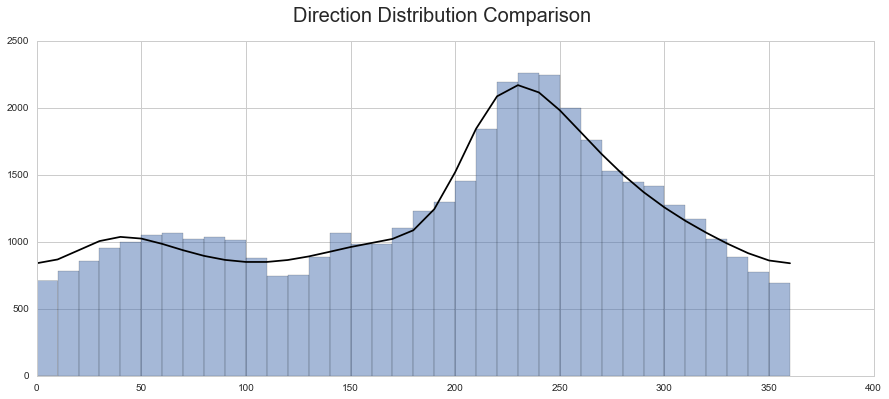

In [52]:
# Calculate Angle Distribution
x_vals = np.linspace(0,2*np.pi, num=36+1)
y_vals_ =[integrate.nquad(f, [[0, inf],[x_val-np.pi/36, x_val+np.pi/36]]) for x_val in x_vals]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y_vals = np.array(zip(*y_vals_)[0])*len(df['dir']) 

bins=np.arange(0, 360 + 1, 10)
df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals/np.pi*180, y_vals,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.show()

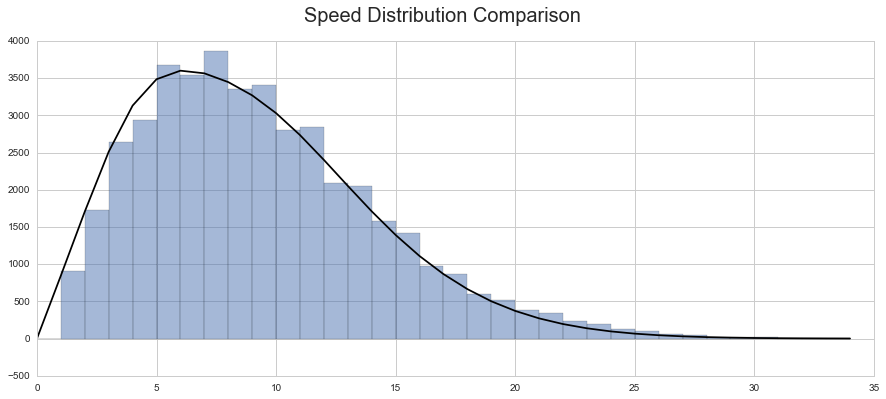

In [53]:
# Calculate Speed Distribution
x_vals = np.arange(0, 35, 1)
y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[0, 2*np.pi]]) for x_val in x_vals]
y_vals = np.array(zip(*y_vals_)[0])*len(df.speed)

df['speed'].hist(bins=x_vals, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals, y_vals,'-', color='black')
plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

In [54]:
# Calculate Speed Distribution
def model_data_comparison(df, incre = 10):
    start, end = 5 + int(incre/2), 360 - int(incre/2)
    for angle in xrange(start, end, incre):
        angle_radian = radians(angle)    
        incre_radian = radians(incre)

        # Number from observation
        start_angle, end_angle = angle-incre/2, angle+incre/2
        sub_df= df[(df['dir'] >= start_angle) & (df['dir'] <= end_angle)] 

        # Number from model
        x_vals = np.arange(0, 35, 1)
        y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x_vals]
        y_vals = np.array(zip(*y_vals_)[0])*len(df.speed)

        sub_df['speed'].hist(bins=x_vals, alpha=0.5,figsize=(15, 3))
        plt.plot(x_vals, y_vals,'-', color='black')

        title = str(start_angle) + '-' +str(end_angle)
        plt.suptitle(title+' Degree Speed Distribution Comparison', fontsize = 15)
        plt.show()

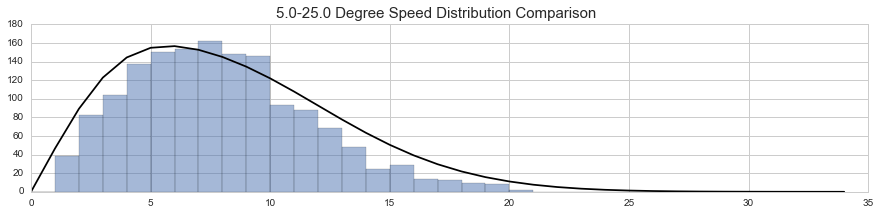

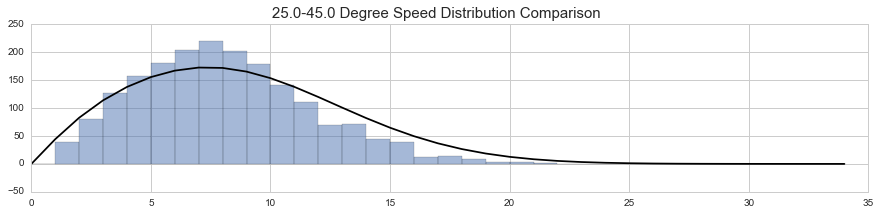

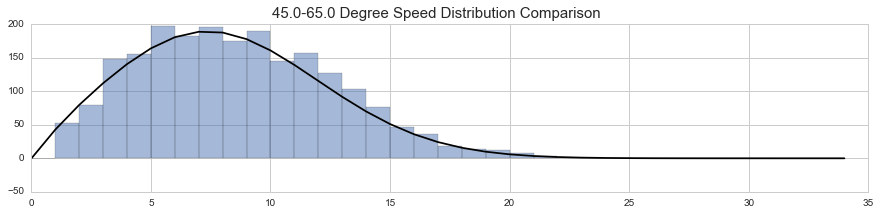

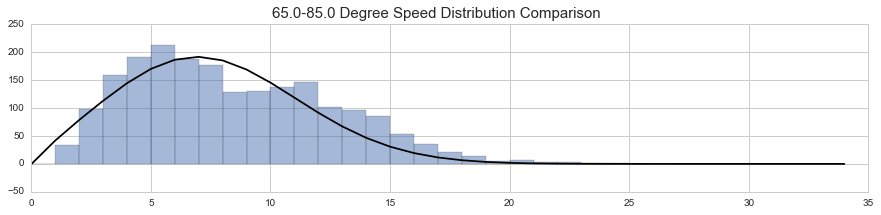

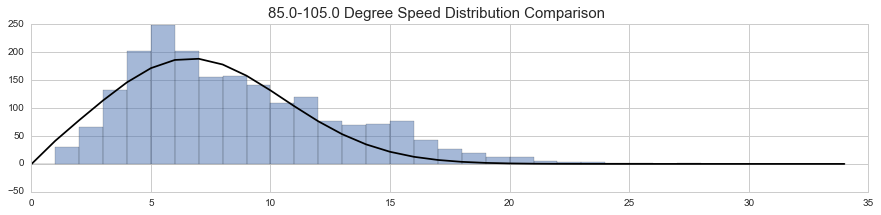

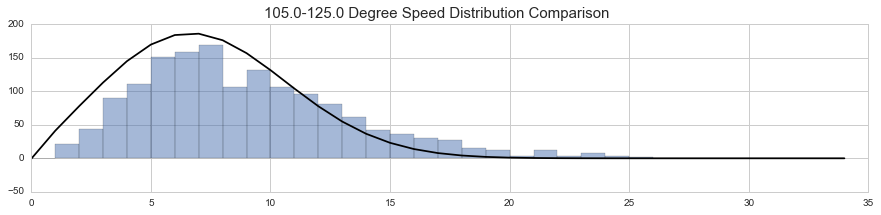

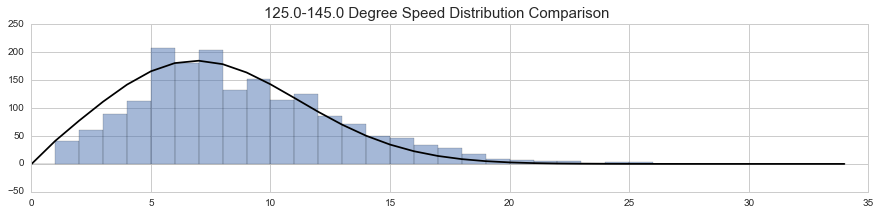

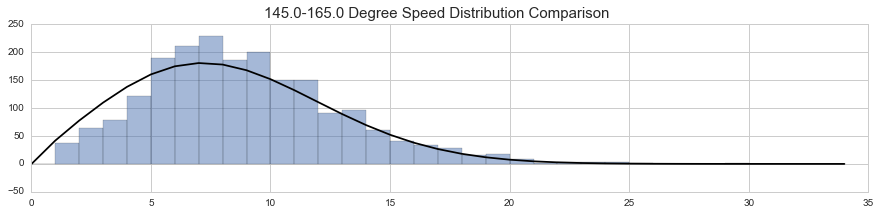

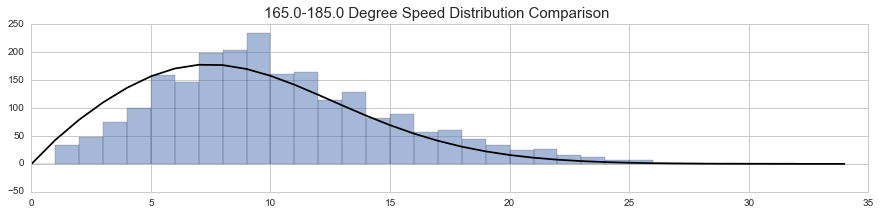

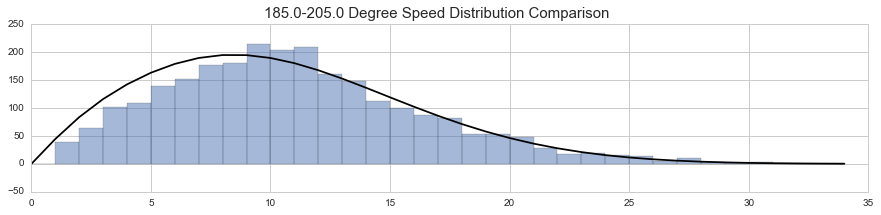

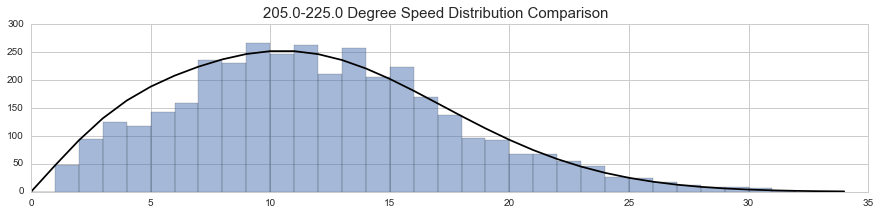

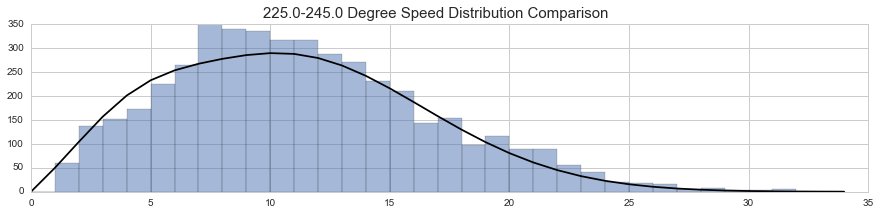

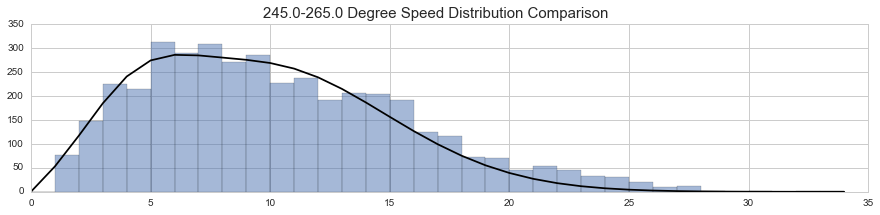

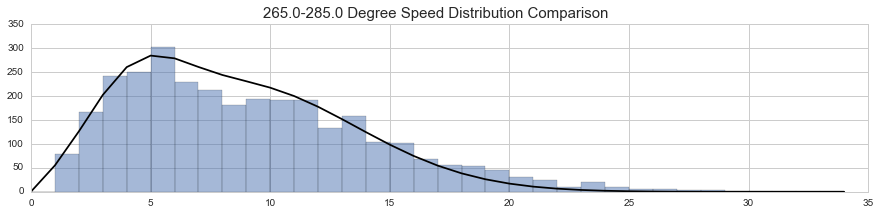

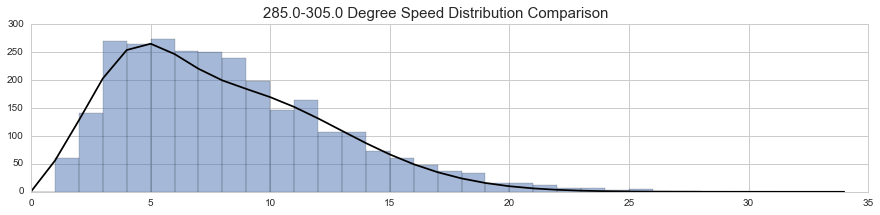

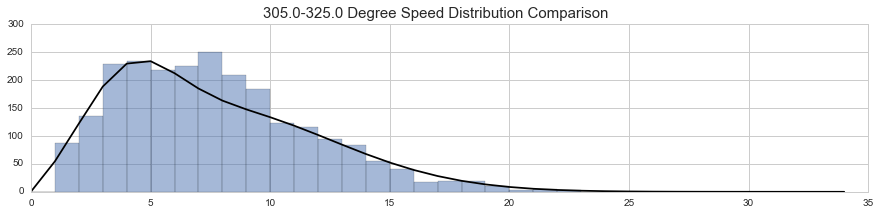

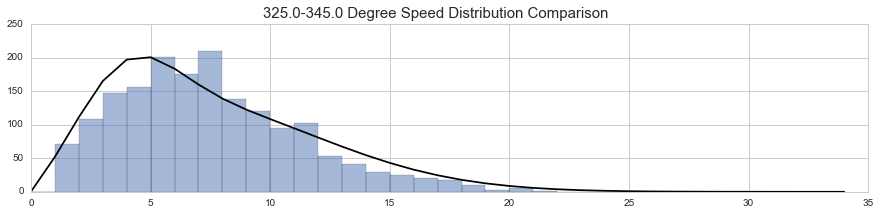

In [55]:
model_data_comparison(df, 20)

In [ ]:
SSS

# Cross Validation, to check the number of ellipse to be fitted

In [ ]:
from sklearn.cross_validation import train_test_split, KFold
    
def fit_gmm(df, number_of_gaussian = 3, print_result = True):
    # 1. Create Input, speed_set
    sample = sub_speed_set = np.array(zip(df.x, df.y))
    points = fitting_range
    
    # 2. KDE + EM fitting
    kde = KernelDensity(bandwidth=1).fit(sample) 
    kde_result = np.exp(kde.score_samples(points))

    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    gmm_em_result = read_gmm_em_result(clf, print_result)
        
    # 3. GMM fitting
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
    cons = [{'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},]
 
    result = sp.optimize.minimize(
        lambda x0: GMM_fit_score(x0, kde_result, method='chi_square'),
        x0,
        bounds = bonds,
        constraints = cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    gmm = group_gmm_param_from_gmm_param_array(result.x)       
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    gmm_pdf_result = mixed_model_pdf(points)
    
    return {
        'gmm' : gmm,
        'kde_result': kde_result,
        'gmm_pdf_result': gmm_pdf_result,
        'number_of_iteration': result.nit}

In [ ]:
## 5-fold cross validation
CV_result_all =[]
print 'Number of train/test dataset', len(df)*4/5, len(df)/5

for number_of_gaussian in xrange(1,6):
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=5, shuffle=True) # each number of gaussian, fit 4 times

    CV_result = []
    for train_index, test_index in kf:
        sub_df = df.iloc[train_index]
        sub_df_test = df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, False)
        gmm_pdf_result_train = result['gmm_pdf_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = np.array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = KernelDensity(bandwidth=1).fit(sample) 
        kde_result_test = np.exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result, 
                                            count = len(sub_df))
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test, 
                                            count = len(sub_df_test))
        
        display(pd.DataFrame([gof_train, gof_test], index=["gof_train", "gof_test"]))
        
        CV_result.append(gof_test)
        
    CV_result_all.append(CV_result)

Number of train/test dataset 34725.6 8681.4
  
Number of gaussian 1


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1443.967520,0.038545,4.403932e-08,0.044655,0.357958,0.934899
gof_test,483.307193,0.037967,5.139422e-08,0.047599,0.386551,0.927261


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1448.245155,0.039691,4.431427e-08,0.044794,0.359074,0.934493
gof_test,440.770388,0.043054,4.684500e-08,0.044811,0.369033,0.929891


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1443.032777,0.038182,4.367138e-08,0.044468,0.356460,0.935443
gof_test,485.699952,0.037433,4.668253e-08,0.043978,0.368322,0.930750


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1446.782381,0.039566,4.418037e-08,0.044726,0.358531,0.934691
gof_test,511.465985,0.043144,5.185491e-08,0.048466,0.388357,0.923454


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,1442.176644,0.038164,4.373183e-08,0.044499,0.356706,0.935354
gof_test,433.603747,0.037447,4.414678e-08,0.045505,0.358956,0.934760


  
Number of gaussian 2


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,852.463351,0.012284,2.736758e-08,0.035202,0.282182,0.959544
gof_test,359.470262,0.015842,3.437917e-08,0.040779,0.315961,0.949164


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,851.358380,0.010639,2.742964e-08,0.035242,0.282502,0.959452
gof_test,314.192287,0.013678,3.239738e-08,0.034834,0.307291,0.953867


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,851.661656,0.010236,2.770167e-08,0.035416,0.283900,0.959050
gof_test,306.281104,0.008149,3.343082e-08,0.039378,0.312068,0.950194


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,850.189250,0.011218,2.743486e-08,0.035245,0.282529,0.959445
gof_test,305.551519,0.012940,3.109202e-08,0.036350,0.300665,0.954724


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,849.839364,0.011182,2.748096e-08,0.035275,0.282766,0.959376
gof_test,269.379480,0.010732,2.661639e-08,0.035800,0.278241,0.960012


  
Number of gaussian 3


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,540.788404,0.011986,1.270417e-08,0.023984,0.192258,0.981220
gof_test,252.456931,0.015507,1.754850e-08,0.028185,0.226083,0.973977


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,540.043233,0.012456,1.264810e-08,0.023931,0.191834,0.981303
gof_test,209.188279,0.015621,1.500559e-08,0.026921,0.209322,0.977869


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,539.789083,0.013020,1.303962e-08,0.024299,0.194780,0.980724
gof_test,274.414233,0.016563,2.102989e-08,0.029263,0.247398,0.969213


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,539.909365,0.009654,1.305762e-08,0.024315,0.194914,0.980698
gof_test,226.208571,0.005016,1.716021e-08,0.026845,0.223252,0.975142


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,538.919941,0.012827,1.303836e-08,0.024297,0.194771,0.980726
gof_test,240.282460,0.019666,1.800933e-08,0.028439,0.228541,0.973453


  
Number of gaussian 4


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,483.956780,0.009457,1.212845e-08,0.023434,0.187851,0.982071
gof_test,204.801665,0.015367,1.589103e-08,0.026770,0.215150,0.976465


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,483.862963,0.010522,1.217770e-08,0.023482,0.188232,0.981998
gof_test,253.012153,0.017023,2.010934e-08,0.027988,0.241892,0.970781


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,405.961650,0.003441,8.925937e-09,0.020104,0.161153,0.986805
gof_test,210.467079,0.005240,1.410284e-08,0.024092,0.202539,0.979281


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,482.255661,0.009084,1.215295e-08,0.023458,0.188041,0.982035
gof_test,196.398989,0.006164,1.368895e-08,0.025896,0.199340,0.979477


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,486.385306,0.010142,1.180213e-08,0.023117,0.185307,0.982554
gof_test,261.443932,0.009726,1.770465e-08,0.028572,0.227119,0.974414


  
Number of gaussian 5


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,282.949032,0.002521,4.132350e-09,0.013679,0.109650,0.993891
gof_test,211.668721,0.010370,1.041364e-08,0.020373,0.173987,0.984911


In [ ]:
for idx, gof_group in enumerate(CV_result_all):
    print 'number of gaussian', idx+1
    display(pd.DataFrame(gof_group))

In [ ]:
mean_gof_all = []
for idx, gof_group in enumerate(CV_result_all):
    mean_gof = np.mean(pd.DataFrame(gof_group))
    mean_gof_all.append(mean_gof)
mean_gof_all = pd.DataFrame(mean_gof_all)
mean_gof_all

In [ ]:
x = [1,2,3,4,5]
for column in ['R_square','Chi_square', 'K_S']:
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 3)
    plt.plot(x, mean_gof_all[column],'-')
    plt.suptitle(column)
    plt.show()